# Цель лабораторной работы
Изучить ансамбли моделей машинного обучения<cite data-cite="ue:lab6"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab6"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество модели с&nbsp;помощью одной из&nbsp;подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра. В&nbsp;зависимости от&nbsp;используемой библиотеки можно применять функцию `GridSearchCV`, использовать перебор параметров в&nbsp;цикле, или использовать другие методы.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [21]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются метрологические данные с&nbsp;метеостанции HI-SEAS (Hawaii Space Exploration Analog and Simulation) за&nbsp;четыре месяца (с&nbsp;сентября по&nbsp;декабрь 2016&nbsp;года)<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("data/heart-disease-uci.zip")

Проверим полученные типы:

In [4]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df = data.copy()

In [7]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

С&nbsp;такими данными уже можно работать. Проверим размер набора данных:

In [8]:
df.shape

(303, 14)

Проверим основные статистические характеристики набора данных:

In [9]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Проверим наличие пропусков в&nbsp;данных:

In [10]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [11]:
X = df.drop("target", axis=1)
y = df["target"]

In [12]:
print(X.head(), "\n")
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0   63    1   3       145   233    1        0      150      0   
1   37    1   2       130   250    0        1      187      0   
2   41    0   1       130   204    0        0      172      0   
3   56    1   1       120   236    0        1      178      0   
4   57    0   0       120   354    0        1      163      1   

   oldpeak  slope  ca  thal  
0      2.3      0   0     1  
1      3.5      0   0     2  
2      1.4      2   0     2  
3      0.8      2   0     2  
4      0.6      2   0     2   

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [13]:
print(X.shape)
print(y.shape)

(303, 13)
(303,)


Предобработаем данные, чтобы методы работали лучше:

In [14]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02
mean,4.690051e-17,-1.407015e-16,2.345026e-17,-7.035077e-16,-1.113887e-16,-2.345026e-17,1.465641e-16,-6.800574e-16,-4.690051e-17,2.345026e-17,-1.407015e-16,-2.345026e-17,-1.641518e-16
std,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00
min,-2.797624e+00,-1.468418e+00,-9.385146e-01,-2.148802e+00,-2.324160e+00,-4.176345e-01,-1.005832e+00,-3.439267e+00,-6.966305e-01,-8.968617e-01,-2.274579e+00,-7.144289e-01,-3.784824e+00
25%,-7.572802e-01,-1.468418e+00,-9.385146e-01,-6.638668e-01,-6.814943e-01,-4.176345e-01,-1.005832e+00,-7.061105e-01,-6.966305e-01,-8.968617e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
50%,6.988599e-02,6.810052e-01,3.203122e-02,-9.273778e-02,-1.210553e-01,-4.176345e-01,8.989622e-01,1.466343e-01,-6.966305e-01,-2.067053e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
75%,7.316189e-01,6.810052e-01,1.002577e+00,4.783913e-01,5.456738e-01,-4.176345e-01,8.989622e-01,7.151309e-01,1.435481e+00,4.834512e-01,9.763521e-01,2.650822e-01,1.123029e+00
max,2.496240e+00,6.810052e-01,1.973123e+00,3.905165e+00,6.140401e+00,2.394438e+00,2.803756e+00,2.289429e+00,1.435481e+00,4.451851e+00,9.763521e-01,3.203615e+00,1.123029e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227, 13)
(76, 13)
(227,)
(76,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [18]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("accuracy:",
          accuracy_score(y_test, model.predict(X_test).round()))
    print("balanced_accuracy:",
          balanced_accuracy_score(y_test, model.predict(X_test).round()))

### Случайный лес

Попробуем случайный лес с&nbsp;гиперпараметром $n=100$:

In [22]:
ran_100 = RandomForestRegressor(n_estimators=100)
ran_100.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [23]:
test_model(ran_100)

mean_absolute_error: 0.2852631578947368
median_absolute_error: 0.22999999999999998
accuracy: 0.7763157894736842
balanced_accuracy: 0.7709677419354839


Видно, что данный метод даже без&nbsp;настройки гиперпараметров уже показывает очень неплохой результат.

### Градиентный бустинг

Попробуем градиентный бустинг с&nbsp;гиперпараметром $n=100$:

In [24]:
gr_100 = GradientBoostingRegressor(n_estimators=100)
gr_100.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [25]:
test_model(gr_100)

mean_absolute_error: 0.3199293287025815
median_absolute_error: 0.22280934092858368
accuracy: 0.7631578947368421
balanced_accuracy: 0.7548387096774194


Внезапно градиентный бустинг оказался несколько хуже по&nbsp;сравнению со&nbsp;случайным лесом.

## Подбор гиперпараметра $n$

### Случайный лес

Введем список настраиваемых параметров:

In [92]:
param_range = np.arange(5, 106, 5)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
          70,  75,  80,  85,  90,  95, 100, 105])}]

Запустим подбор параметра:

In [93]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10),
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

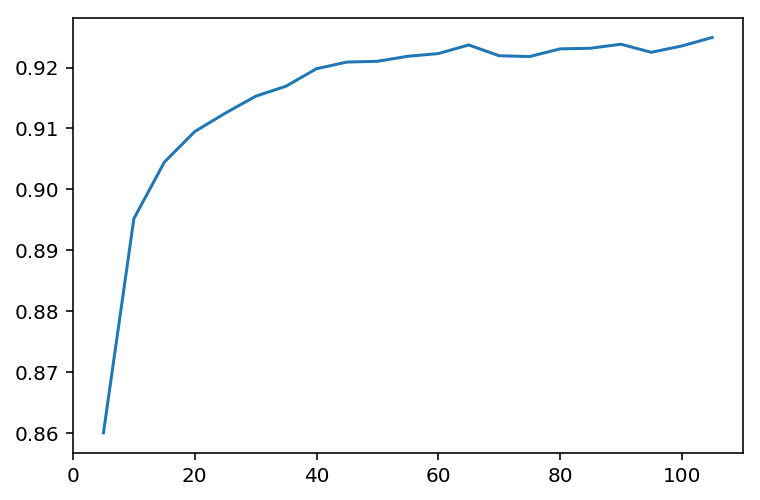

In [94]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В&nbsp;целом результат ожидаемый&nbsp;— чем больше обученных моделей, тем лучше.

На&nbsp;тестовом наборе данных картина похожа:

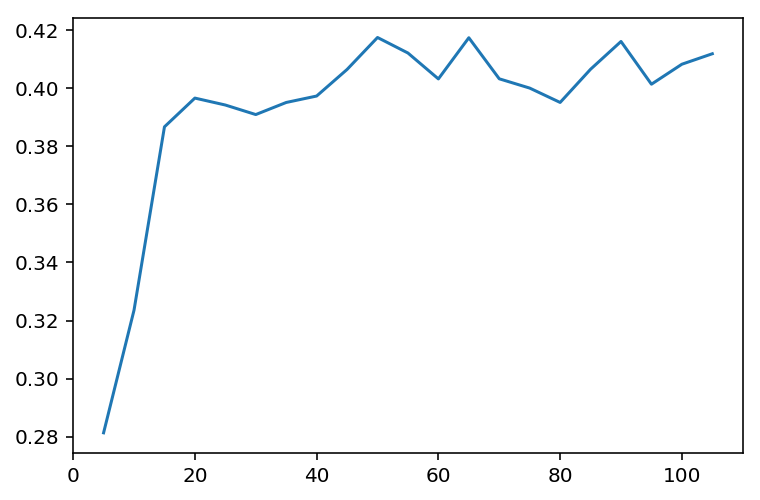

In [96]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Из-за случайнойсти график немного плавает, но конкретно в&nbsp;данном случае получился чётко выраженный пик с&nbsp;наилучшим результатом.

In [97]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.26999999999999996
median_absolute_error: 0.18000000000000005
accuracy: 0.7763157894736842
balanced_accuracy: 0.7759856630824373


Конкретно данная модель оказалась заметно лучше, чем исходная.

### Градиентный бустинг

Список настраиваемых параметров оставим тем же.

In [98]:
tuned_parameters

[{'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
          70,  75,  80,  85,  90,  95, 100, 105])}]

Запустим подбор параметра:

In [99]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10),
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

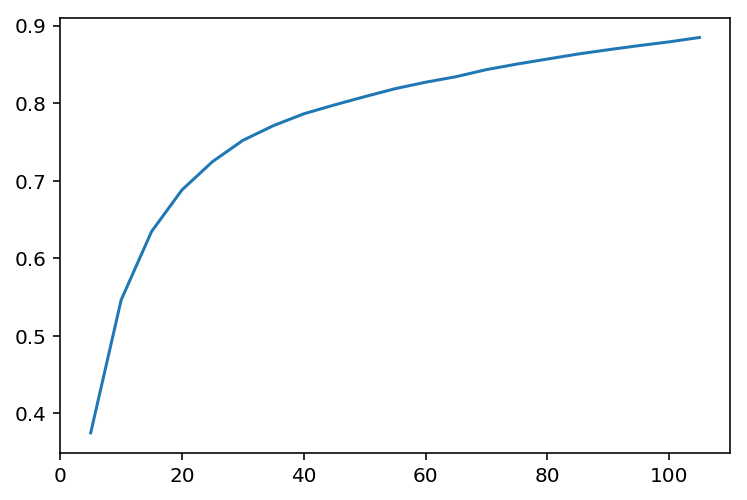

In [100]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Картина та же: чем больше подмоделей, тем лучше.

На&nbsp;тестовом наборе данных картина ровно та же:

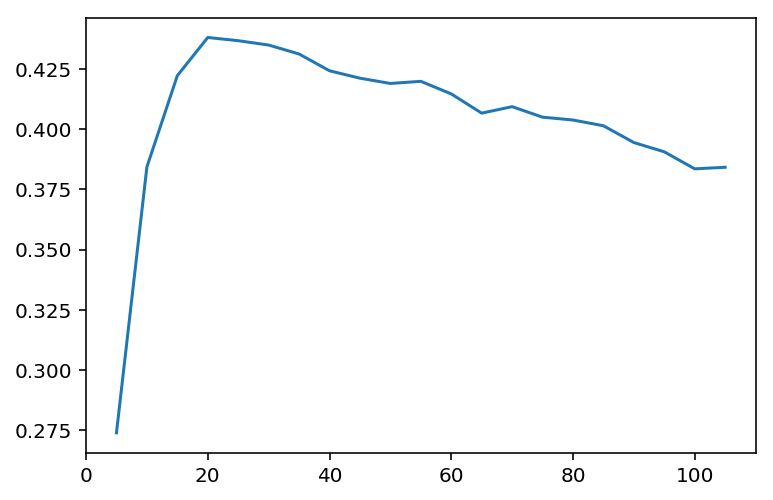

In [101]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Выходит, что чем больше подмоделей, тем лучше. Возможно, что можно использовать ещё больше моделей, но будем считать, что это выходит за&nbsp;рамки лабораторной работы.

In [102]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.3101250497756783
median_absolute_error: 0.2327059612618121
accuracy: 0.75
balanced_accuracy: 0.7437275985663083
